# Терешенков Александр БВТ2203. Курсовая работа

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
import torch.optim as optim

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Свои линейные слои

In [3]:
class MyNormalLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.normal(0, 0.1, size=(in_features, out_features)))
        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

In [4]:
class MyLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.randn(in_features, out_features) * (1.0 / in_features**0.5))

        if bias:
            self.bias = nn.Parameter(torch.zeros(out_features))
        else:
            self.bias = None

    def forward(self, x):
        out = x @ self.weight
        if self.bias is not None:
            out += self.bias
        return out

## Свои функции активации

In [5]:
class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.clamp(x, min=0)

In [6]:
class CustomTanh(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.tanh(x)

## Обучение и тестирование моделей с самописными классами линейных слоев и функций активации

In [7]:
class MNISTAutoEncoder(nn.Module):
    def __init__(self, MyLinear, ActivationFun):
        super(MNISTAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            MyLinear(28 * 28, 128),
            ActivationFun(),
            MyLinear(128, 64),
            ActivationFun(),
            MyLinear(64, 36),
            ActivationFun(),
            MyLinear(36, 18),
            ActivationFun(),
            MyLinear(18, 9)
        )
        self.decoder = nn.Sequential(
            MyLinear(9, 18),
            ActivationFun(),
            MyLinear(18, 36),
            ActivationFun(),
            MyLinear(36, 64),
            ActivationFun(),
            MyLinear(64, 128),
            ActivationFun(),
            MyLinear(128, 28 * 28),
            ActivationFun()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [8]:
def add_noise(images, mean=0., std=0.1):
    noise = torch.randn_like(images) * std + mean
    noisy_images = images + noise
    noisy_images = torch.clamp(noisy_images, 0., 1.)
    return noisy_images

In [9]:
def train_denoising_autoencoder(model, train_loader, optimizer, criterion, num_epochs=50):
    model.train()
    train_losses = []
    
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for batch_idx, (data, _) in enumerate(train_loader):

            data = data.view(data.size(0), -1).to(device)  # [batch_size, 784]

            noisy_data = add_noise(data, std=0.8)
            optimizer.zero_grad()
            outputs = model(noisy_data)
            loss = criterion(outputs, data)

            loss.backward()
            optimizer.step()
            
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)
        train_losses.append(avg_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.6f}')
    
    return train_losses

In [10]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)) # Mean and std for MNIST
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

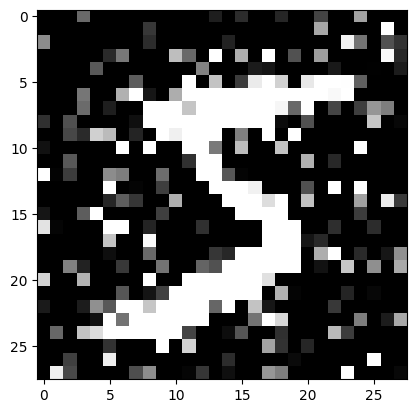

In [11]:
plt.imshow(add_noise(train_dataset[0][0], std=0.8).numpy().squeeze(), cmap="gray")

In [12]:
model_normal_relu = MNISTAutoEncoder(MyNormalLinear, CustomReLU).to(device)
criterion_normal_relu = nn.MSELoss()
optimizer_normal_relu = optim.Adam(model_normal_relu.parameters(), lr=0.001)

model_reg_relu = MNISTAutoEncoder(MyLinear, CustomReLU).to(device)
criterion_reg_relu = nn.MSELoss()
optimizer_reg_relu = optim.Adam(model_reg_relu.parameters(), lr=0.001)

model_normal_tanh = MNISTAutoEncoder(MyNormalLinear, CustomTanh).to(device)
criterion_normal_tanh = nn.MSELoss()
optimizer_normal_tanh = optim.Adam(model_normal_tanh.parameters(), lr=0.001)

model_reg_tanh = MNISTAutoEncoder(MyLinear, CustomTanh).to(device)
criterion_reg_tanh = nn.MSELoss()
optimizer_reg_tanh = optim.Adam(model_reg_tanh.parameters(), lr=0.001)

In [13]:
losses_1 = train_denoising_autoencoder(model_normal_relu, train_loader, optimizer_normal_relu, criterion_normal_relu)
print("----------------------------")
losses_2 = train_denoising_autoencoder(model_reg_relu, train_loader, optimizer_reg_relu, criterion_reg_relu)

Epoch [1/50], Average Loss: 0.733727
Epoch [2/50], Average Loss: 0.618521
Epoch [3/50], Average Loss: 0.569032
Epoch [4/50], Average Loss: 0.536580
Epoch [5/50], Average Loss: 0.523361
Epoch [6/50], Average Loss: 0.513776
Epoch [7/50], Average Loss: 0.501203
Epoch [8/50], Average Loss: 0.480845
Epoch [9/50], Average Loss: 0.467870
Epoch [10/50], Average Loss: 0.457449
Epoch [11/50], Average Loss: 0.450804
Epoch [12/50], Average Loss: 0.446292
Epoch [13/50], Average Loss: 0.442634
Epoch [14/50], Average Loss: 0.439842
Epoch [15/50], Average Loss: 0.437034
Epoch [16/50], Average Loss: 0.434363
Epoch [17/50], Average Loss: 0.431967
Epoch [18/50], Average Loss: 0.429397
Epoch [19/50], Average Loss: 0.426119
Epoch [20/50], Average Loss: 0.423155
Epoch [21/50], Average Loss: 0.420479
Epoch [22/50], Average Loss: 0.417901
Epoch [23/50], Average Loss: 0.416078
Epoch [24/50], Average Loss: 0.414531
Epoch [25/50], Average Loss: 0.412900
Epoch [26/50], Average Loss: 0.411521
Epoch [27/50], Averag

In [14]:
losses_3 = train_denoising_autoencoder(model_normal_tanh, train_loader, optimizer_normal_tanh, criterion_normal_tanh)
print("----------------------------")
losses_4 = train_denoising_autoencoder(model_reg_tanh, train_loader, optimizer_reg_tanh, criterion_reg_tanh)

Epoch [1/50], Average Loss: 0.659205
Epoch [2/50], Average Loss: 0.596325
Epoch [3/50], Average Loss: 0.563767
Epoch [4/50], Average Loss: 0.546762
Epoch [5/50], Average Loss: 0.534209
Epoch [6/50], Average Loss: 0.522191
Epoch [7/50], Average Loss: 0.511979
Epoch [8/50], Average Loss: 0.505662
Epoch [9/50], Average Loss: 0.501076
Epoch [10/50], Average Loss: 0.497054
Epoch [11/50], Average Loss: 0.493662
Epoch [12/50], Average Loss: 0.490093
Epoch [13/50], Average Loss: 0.486522
Epoch [14/50], Average Loss: 0.483727
Epoch [15/50], Average Loss: 0.481531
Epoch [16/50], Average Loss: 0.479444
Epoch [17/50], Average Loss: 0.477461
Epoch [18/50], Average Loss: 0.475226
Epoch [19/50], Average Loss: 0.473219
Epoch [20/50], Average Loss: 0.470649
Epoch [21/50], Average Loss: 0.468125
Epoch [22/50], Average Loss: 0.466207
Epoch [23/50], Average Loss: 0.464682
Epoch [24/50], Average Loss: 0.463392
Epoch [25/50], Average Loss: 0.462001
Epoch [26/50], Average Loss: 0.460629
Epoch [27/50], Averag

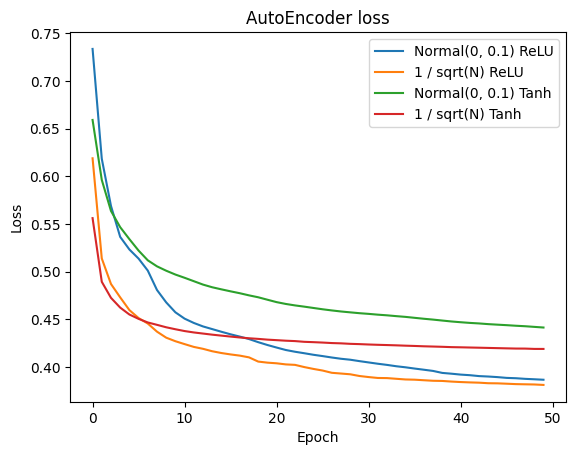

In [18]:
plt.plot(losses_1, label="Normal(0, 0.1) ReLU")
plt.plot(losses_2, label="1 / sqrt(N) ReLU")
plt.plot(losses_3, label="Normal(0, 0.1) Tanh")
plt.plot(losses_4, label="1 / sqrt(N) Tanh")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("AutoEncoder loss")
plt.show()

In [16]:
def test_model(model_1, model_2, model_3, model_4):
    model_1.eval()
    model_2.eval()
    model_3.eval()
    model_4.eval()

    for i in range(5):
        noisy_img = add_noise(train_dataset[i][0], std=0.7)
        denoised_img_1 = model_1.decoder(model_1.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))
        denoised_img_2 = model_2.decoder(model_2.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))
        denoised_img_3 = model_3.decoder(model_3.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))
        denoised_img_4 = model_4.decoder(model_4.encoder(noisy_img.view(noisy_img.size(0), -1).to(device)))

        denoised_img_1 = denoised_img_1.view(-1, 1, 28, 28).cpu()
        denoised_img_2 = denoised_img_2.view(-1, 1, 28, 28).cpu()
        denoised_img_3 = denoised_img_1.view(-1, 1, 28, 28).cpu()
        denoised_img_4 = denoised_img_2.view(-1, 1, 28, 28).cpu()

        plt.figure(figsize=(7, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(noisy_img.numpy().squeeze(), cmap="gray")
        plt.title('Image 1')
        plt.axis('off')


        plt.subplot(1, 5, 2)
        plt.imshow(denoised_img_1.cpu().detach().numpy().squeeze(), "gray")
        plt.title('N. ReLU')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(denoised_img_2.cpu().detach().numpy().squeeze(), "gray")
        plt.title('R. ReLU')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(denoised_img_3.cpu().detach().numpy().squeeze(), "gray")
        plt.title('N. Tanh')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(denoised_img_4.cpu().detach().numpy().squeeze(), "gray")
        plt.title('R. Tanh')
        plt.axis('off')

        plt.tight_layout()

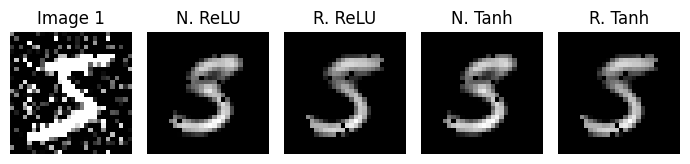

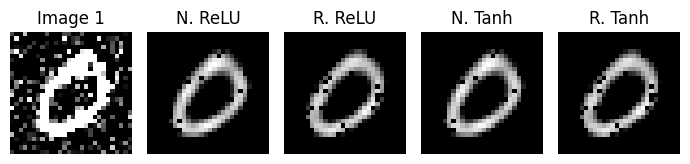

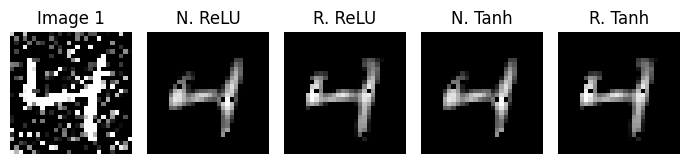

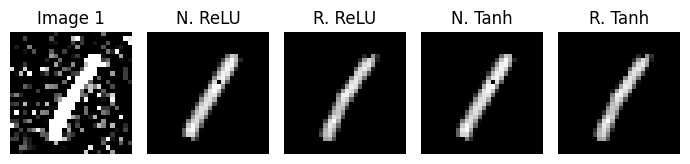

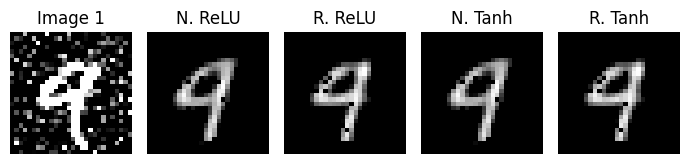

In [17]:
test_model(model_normal_relu, model_reg_relu, model_normal_tanh, model_reg_tanh)